# Build a classification model: Delicious Asian and Indian Cuisines


## Cuisine classifiers 1

In this lesson, we'll explore various classifiers to *predict the national cuisine based on a set of ingredients.* Along the way, we'll learn more about how algorithms can be used for classification tasks.

### [**Pre-lecture quiz**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Preparation**

This lesson builds on our [previous lesson](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), where we:

-   Introduced classifications using a dataset featuring the amazing cuisines of Asia and India 😋.

-   Explored some [dplyr verbs](https://dplyr.tidyverse.org/) to prepare and clean our data.

-   Created beautiful visualizations using ggplot2.

-   Showed how to handle imbalanced data by preprocessing it with [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstrated how to `prep` and `bake` our recipe to ensure it works as expected.

#### **Prerequisite**

For this lesson, we'll need the following packages to clean, prepare, and visualize our data:

-   `tidyverse`: The [tidyverse](https://www.tidyverse.org/) is a [collection of R packages](https://www.tidyverse.org/packages) designed to make data science faster, easier, and more enjoyable!

-   `tidymodels`: The [tidymodels](https://www.tidymodels.org/) framework is a [collection of packages](https://www.tidymodels.org/packages/) for modeling and machine learning.

-   `themis`: The [themis package](https://themis.tidymodels.org/) provides additional recipe steps for handling imbalanced data.

-   `nnet`: The [nnet package](https://cran.r-project.org/web/packages/nnet/nnet.pdf) offers functions for estimating feed-forward neural networks with a single hidden layer and for multinomial logistic regression models.

You can install them as:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternatively, the script below verifies if you have the necessary packages to complete this module and installs them for you if they are not already installed.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Split the data into training and test sets.

We'll begin by revisiting a few steps from our previous lesson.

### Remove the most common ingredients that cause confusion between different cuisines, using `dplyr::select()`.

Who doesn't love rice, garlic, and ginger!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfect! Now, time to divide the data so that 70% is allocated for training and 30% for testing. We'll also use a `stratification` method during the split to `preserve the proportion of each cuisine` in both the training and validation datasets.

[rsample](https://rsample.tidymodels.org/), a package within Tidymodels, offers tools for efficient data splitting and resampling:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Deal with imbalanced data

As you may have noticed in the original dataset and our training set, the number of cuisines is quite unevenly distributed. Korean cuisines are *almost* three times more than Thai cuisines. Imbalanced data often negatively impacts model performance. Many models perform best when the number of observations is balanced, and therefore, they tend to struggle with unbalanced data.

There are primarily two ways to address imbalanced datasets:

-   Adding observations to the minority class: `Over-sampling`, for example, using a SMOTE algorithm, which synthetically generates new examples of the minority class based on the nearest neighbors of those cases.

-   Removing observations from the majority class: `Under-sampling`

In our previous lesson, we showed how to handle imbalanced datasets using a `recipe`. A recipe can be thought of as a blueprint that outlines the steps to be applied to a dataset to prepare it for data analysis. In our case, we aim to achieve an equal distribution of cuisines in our `training set`. Let's dive right in.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

You can, of course, confirm (using prep + bake) that the recipe works as expected—all the cuisine labels have `559` observations.

Since we'll be using this recipe as a preprocessor for modeling, a `workflow()` will handle all the prep and bake steps for us, so we won't need to manually estimate the recipe.

Now we're ready to train a model 👩‍💻👨‍💻!

## 3. Choosing your classifier

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Artwork by @allison_horst</figcaption>


Now we have to decide which algorithm to use for the task 🤔.

In Tidymodels, the [`parsnip package`](https://parsnip.tidymodels.org/index.html) provides a consistent interface for working with models across different engines (packages). Please refer to the parsnip documentation to explore [model types & engines](https://www.tidymodels.org/find/parsnip/#models) and their corresponding [model arguments](https://www.tidymodels.org/find/parsnip/#model-args). The variety can be quite overwhelming at first glance. For example, the following methods all include classification techniques:

-   C5.0 Rule-Based Classification Models

-   Flexible Discriminant Models

-   Linear Discriminant Models

-   Regularized Discriminant Models

-   Logistic Regression Models

-   Multinomial Regression Models

-   Naive Bayes Models

-   Support Vector Machines

-   Nearest Neighbors

-   Decision Trees

-   Ensemble methods

-   Neural Networks

And the list goes on!

### **Which classifier should we choose?**

So, which classifier should you go with? Often, testing several options and looking for a good result is one way to approach it.

> AutoML simplifies this process by running these comparisons in the cloud, helping you select the best algorithm for your data. Try it [here](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Additionally, the choice of classifier depends on the problem at hand. For example, when the outcome can be categorized into `more than two classes`, as in our case, you need to use a `multiclass classification algorithm` instead of `binary classification.`

### **A smarter approach**

A better alternative to random guessing is to follow the guidance provided in this downloadable [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Here, we find that for our multiclass problem, we have several options:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>A section of Microsoft's Algorithm Cheat Sheet, outlining multiclass classification options</figcaption>


### **Reasoning**

Let's explore different approaches based on the constraints we have:

-   **Deep Neural Networks are too complex**. Given our clean but small dataset, and the fact that we are training locally using notebooks, deep neural networks are overly complicated for this task.

-   **No binary classifier**. We are not using a binary classifier, so one-vs-all is not an option.

-   **Decision tree or logistic regression might be suitable**. A decision tree could work, or we could use multinomial regression/multiclass logistic regression for multiclass data.

-   **Multiclass Boosted Decision Trees address a different problem**. Multiclass boosted decision trees are better suited for nonparametric tasks, such as building rankings, so they are not relevant for our needs.

Additionally, before diving into more complex machine learning models like ensemble methods, it's generally a good idea to start with the simplest model to understand the data better. For this lesson, we'll begin with a `multinomial regression` model.

> Logistic regression is a method used when the outcome variable is categorical (or nominal). Binary logistic regression is applied when there are two outcome categories, while multinomial logistic regression is used when there are more than two outcome categories. For more details, see [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html).

## 4. Train and evaluate a Multinomial logistic regression model.

In Tidymodels, `parsnip::multinom_reg()` defines a model that uses linear predictors to forecast multiclass data based on the multinomial distribution. Refer to `?multinom_reg()` for details on the various methods/engines available to fit this model.

For this example, we'll fit a Multinomial regression model using the default [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) engine.

> I chose a value for `penalty` somewhat arbitrarily. There are better ways to select this value, such as using `resampling` and `tuning` the model, which we will cover later.
>
> Check out [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) if you'd like to learn more about tuning model hyperparameters.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Great job 🥳! Now that we have a recipe and a model specification, we need to find a way to combine them into an object that will first preprocess the data, then fit the model on the preprocessed data, and also allow for potential post-processing activities. In Tidymodels, this handy object is called a [`workflow`](https://workflows.tidymodels.org/) and conveniently organizes your modeling components! This is what we would refer to as *pipelines* in *Python*.

So let's package everything into a workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! A **`workflow()`** can be fit in much the same way a model can. So, time to train a model!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

The output displays the coefficients that the model learned during training.

### Evaluate the Trained Model

Now it's time to assess how well the model performed 📏 by testing it on a separate dataset! Start by generating predictions for the test set.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Great job! In Tidymodels, evaluating model performance can be done using [yardstick](https://yardstick.tidymodels.org/) - a package used to measure the effectiveness of models using performance metrics. As we did in our logistic regression lesson, let's begin by computing a confusion matrix.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

When dealing with multiple classes, it's generally more intuitive to visualize this as a heat map, like this:


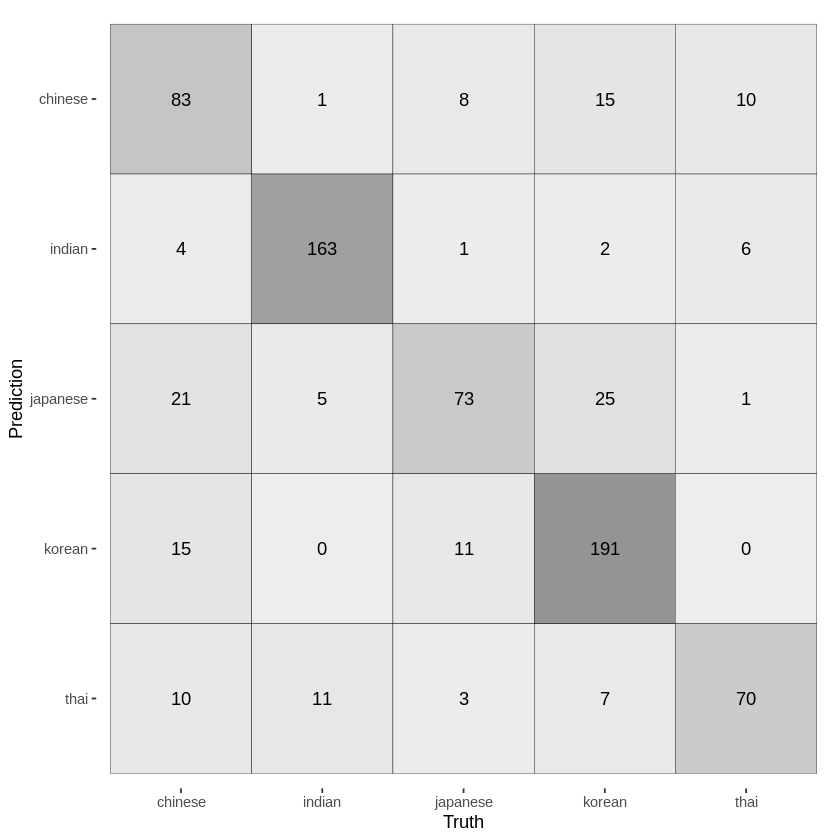

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

The darker squares in the confusion matrix plot represent a high number of cases, and ideally, you should notice a diagonal line of darker squares, which indicates instances where the predicted label matches the actual label.

Next, let's compute summary statistics for the confusion matrix.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

If we focus on metrics like accuracy, sensitivity, and PPV, we're off to a pretty good start 🥳!

## 4. Digging Deeper

Let's consider a subtle question: What determines the choice of a specific cuisine as the predicted outcome?

Statistical machine learning algorithms, such as logistic regression, rely on `probability`. What a classifier actually predicts is a probability distribution across a range of possible outcomes. The class with the highest probability is then selected as the most likely outcome based on the given observations.

Let's explore this further by generating both hard class predictions and probabilities.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Much better!

✅ Can you explain why the model is confident that the first observation corresponds to Thai cuisine?

## **🚀Challenge**

In this lesson, you used your cleaned data to build a machine learning model capable of predicting a national cuisine based on a list of ingredients. Take some time to explore the [many options](https://www.tidymodels.org/find/parsnip/#models) Tidymodels offers for classifying data and [other approaches](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) for fitting multinomial regression models.

#### THANK YOU TO:

[`Allison Horst`](https://twitter.com/allison_horst/) for creating the wonderful illustrations that make R more approachable and fun. You can find more of her work in her [gallery](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) and [Jen Looper](https://www.twitter.com/jenlooper) for developing the original Python version of this module ♥️

<br>
I would have added some jokes, but I donut really get food puns 😅.

<br>

Happy Learning,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Disclaimer**:  
This document has been translated using the AI translation service [Co-op Translator](https://github.com/Azure/co-op-translator). While we aim for accuracy, please note that automated translations may include errors or inaccuracies. The original document in its native language should be regarded as the authoritative source. For critical information, professional human translation is advised. We are not responsible for any misunderstandings or misinterpretations resulting from the use of this translation.
